# Data Preparation
Prepare data from GIS output for optimization model. Requires data by PPIC region (Kern County, Southeast, or Southwest are within analysis scope).

### Inputs:
* Shapefiles of ag fields with crop type ('Crop2014'), area in acres ('Acres'), field identifier ('FID_*County*'). 
    * Expected in `../spatial/` with County name ('Fresno', 'Tulare', 'Kings', 'Kern') appended to `'_fields'` (e.g, `'Fresno_fields.shp`').
* csv of conservation factor scores ('FID_*County*_fields', 'TNC', 'Krat', 'Kitfox', 'Corridors', 'CPAD'). 
    * Expected in `../data/` with County name ('Fresno', 'Tulare', 'Kings', 'Kern') appended to `'_score'` (e.g, `'Fresno_score.csv'`).
* PPIC region shapefile with region code ('PPIC_Region': 'KR', 'NE', 'NW', 'SE', 'SW')
    * Expected in `../spatial/PPIC_Region.shp`
* csv to crosswalk LandIQ crop types with PPIC crop types
    * Expected in `../data/crop_x.csv`
* csv of rotation-adjusted price per acre ('AdjustedPrice'). Note these data were developed for Kern county and other counties are assumed to be equivalent.
    * Expected in`../data/crop_price.csv`
* csv of crop water consumption per acre ('*County*_AW').
    * Expected in`../data/crop_water.csv`

### Output:
* shapefile with per field ag data and conservation factor scores for entire analysis area.

### Process Overview:
1. Spatial join the county ag field shapefiles with PPIC region shapefile
2. For each region in the PPIC regions ('KR', 'SW', 'SE'):
    1. Lookup PPIC crop code from crop_x table
    2. Calculate price per acre
    3. Normalize conservation factors not already on a 1 - 100 scale
    4. Calculate area-weighted conservation production per field

## Inputs

Confirm the inputs

In [1]:
# Inputs
counties = ['Fresno', 'Tulare', 'Kings', 'Kern']
regions = ['KR', 'SE', 'SW']
ppic = r'../spatial/PPIC_Region.shp'
crop_x_table = r'../data/crop_x.csv'
crop_price_table = r'../data/crop_price.csv'
crop_water_table = r'../data/crop_water.csv'


# Path to output, use as input to future notebooks
out_shp = r'../outputs/fields_shape.shp'

## Processing

In [2]:
# Import statements
import pandas as pd
import numpy as np
import geopandas as gd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style("white")

In [4]:
plt.rcParams["figure.figsize"] = (12,5)

## Read in Data

### Read in Conservation Factor Data

In [5]:
# Read in conservation factor scores, create new County column to identify county, 
# standardize all FID columns to 'FID', and combine
field_dfs = []
for county in counties:
    df = pd.read_csv('../data/' + county + '_score.csv')
    df.rename(columns={f'FID_{county}_fields': 'FID'}, inplace=True)
    df['County'] = county
    field_dfs.append(df)
df = pd.concat(field_dfs, sort=False)
df.head()

,FID,TNC,Krat,Kitfox,Corridors,CPAD,County
0,0,0.0,0.0,0.0,0.0,0.0,Fresno
1,1,0.0,0.0,0.0,0.0,0.0,Fresno
2,2,0.0,0.0,0.0,0.0,0.0,Fresno
3,3,0.0,0.0,0.0,0.0,0.0,Fresno
4,4,0.0,0.0,0.0,0.0,0.0,Fresno


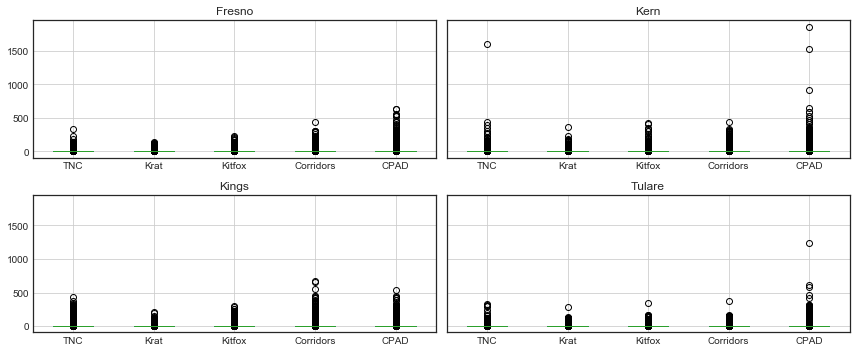

In [6]:
df[['TNC', 'Krat', 'Kitfox', 'Corridors', 'CPAD', 'County']].groupby('County').boxplot()
plt.tight_layout()

### Read in Field Spatial Data

In [7]:
# Read in field shapefiles, drop extraneous columns, create new County column to identify county, 
# standardize all FID columns to 'FID', and combine
shp_list = []

for county in counties:
    shp = gd.read_file(f'../spatial/{county}_fields.shp')
    shp = shp[['Crop2014', 'Acres', f'FID_{county}', 'geometry']]
    shp.rename(columns={f'FID_{county}': 'FID'}, inplace=True)
    shp['County'] = county
    shp_list.append(shp)
    
fields = gd.GeoDataFrame(pd.concat(shp_list, ignore_index=True, sort=False))
fields.crs = {'init': 'epsg:6414'}
fields = fields.to_crs(epsg=3857)

In [8]:
fields.crs

{'init': 'epsg:3857', 'no_defs': True}

In [9]:
fields.head()

,Crop2014,Acres,FID,geometry,County
0,Grapes,43.474109,0,POLYGON Z ((-13355020.09666443 4407864.0678736...,Fresno
1,Grapes,93.723265,1,POLYGON Z ((-13331506.86330624 4374173.2907541...,Fresno
2,Peaches/Nectarines,6.409884,2,POLYGON Z ((-13304207.15885581 4380620.8643907...,Fresno
3,Grapes,17.461519,3,POLYGON Z ((-13331417.48071155 4381217.4603662...,Fresno
4,Grapes,9.365854,4,POLYGON Z ((-13339076.40436587 4383454.6129433...,Fresno


### Read in PPIC Spatial Data 

In [10]:
ppic_regions = gd.read_file(ppic)
ppic_regions = ppic_regions.to_crs(epsg=3857)
ppic_regions

,OBJECTID,PPIC_Regio,Shape_Leng,Shape_Area,geometry
0,1,KR,1.029789e+06,1.212854e+10,"POLYGON ((-13247038.307 4287718.055399997, -13..."
1,2,NE,8.712062e+05,1.149217e+10,"POLYGON ((-13501488.6241 4565348.2922, -135001..."
2,3,NW,7.630251e+05,4.508380e+09,"POLYGON ((-13502420.0527 4535907.504600001, -1..."
3,4,SE,1.069165e+06,9.642920e+09,"POLYGON ((-13325232.1049 4434083.094999996, -1..."
4,5,SW,8.410650e+05,1.094927e+10,"POLYGON ((-13371112.014 4413205.373400005, -13..."


### Read in Crop Crosswalk to PPIC table

In [11]:
crop_x = pd.read_csv(crop_x_table)
crop_x.head() 

,Crop,Crop_PPIC
0,Alfalfa and Alfalfa Mixtures,alfalfa-pasture
1,Almonds,trees-vines
2,Apples,veg-fruits
3,Avocados,trees-vines
4,Beans (Dry),veg-fruits


### Read in Crop Info Table

In [12]:
crop_price = pd.read_csv(crop_price_table)
crop_price.head()

,Crop,Price,Rotations,AdjustedPrice
0,Alfalfa and Alfalfa Mixtures,1113.653444,1.000000,1113.653444
1,Almonds,5995.531797,1.000000,5995.531797
2,Apples,1657.747573,1.000000,1657.747573
3,Avocados,13099.103230,1.000000,13099.103230
4,Beans (Dry),1060.225352,1.935484,2052.049069


In [13]:
crop_water = pd.read_csv(crop_water_table)
crop_water.head()

,Crop,Kern_AW,Fresno_AW,Kings_AW,Tulare_AW
0,Alfalfa and Alfalfa Mixtures,5.08,4.589778,4.945137,5.125525
1,Almonds,4.54,3.521685,3.884410,3.889192
2,Apples,3.63,3.795877,3.985478,3.767993
3,Avocados,3.53,2.773072,3.172853,3.117050
4,Beans (Dry),3.26,2.137108,2.784316,3.071122


## Set Up Analysis

### Identify PPIC region

In [14]:
fields = gd.sjoin(fields, ppic_regions)

In [15]:
fields.groupby('PPIC_Regio')['County'].value_counts()

PPIC_Regio  County
KR          Kern      18651
            Tulare      707
            Kings         2
NW          Fresno     2381
SE          Tulare    29679
            Fresno    20113
            Kings      1487
            Kern         20
SW          Fresno    11178
            Kings      7100
            Kern         43
            Tulare       18
Name: County, dtype: int64

In [16]:
fields = fields[['Crop2014', 'Acres', 'FID', 'geometry', 'County', 'PPIC_Regio']]

In [17]:
fields.head()

,Crop2014,Acres,FID,geometry,County,PPIC_Regio
0,Grapes,43.474109,0,POLYGON Z ((-13355020.09666443 4407864.0678736...,Fresno,SE
1,Grapes,93.723265,1,POLYGON Z ((-13331506.86330624 4374173.2907541...,Fresno,SE
2,Peaches/Nectarines,6.409884,2,POLYGON Z ((-13304207.15885581 4380620.8643907...,Fresno,SE
3,Grapes,17.461519,3,POLYGON Z ((-13331417.48071155 4381217.4603662...,Fresno,SE
4,Grapes,9.365854,4,POLYGON Z ((-13339076.40436587 4383454.6129433...,Fresno,SE


### Cross-walk crop type to PPIC crop type

In [18]:
# Set up a list to track the columns that will be aggregated/optimized for ecosystem service benefits
eco_service_cols = np.array([])

In [19]:
fields = fields.join(crop_x.set_index('Crop'), on='Crop2014')

In [20]:
fields.head()

,Crop2014,Acres,FID,geometry,County,PPIC_Regio,Crop_PPIC
0,Grapes,43.474109,0,POLYGON Z ((-13355020.09666443 4407864.0678736...,Fresno,SE,trees-vines
1,Grapes,93.723265,1,POLYGON Z ((-13331506.86330624 4374173.2907541...,Fresno,SE,trees-vines
2,Peaches/Nectarines,6.409884,2,POLYGON Z ((-13304207.15885581 4380620.8643907...,Fresno,SE,trees-vines
3,Grapes,17.461519,3,POLYGON Z ((-13331417.48071155 4381217.4603662...,Fresno,SE,trees-vines
4,Grapes,9.365854,4,POLYGON Z ((-13339076.40436587 4383454.6129433...,Fresno,SE,trees-vines


In [21]:
# Temporary save point after spatial join
# fields.to_file('../outputs/fields_shape.shp')
# fields = gd.read_file('../outputs/fields_shape.shp')
# eco_service_cols = np.array([])

### Calculate Price per Acre

In [22]:
fields = fields.join(crop_price.set_index('Crop'), on='Crop2014')

#### Calculate FieldCropPrice column
Will be used to sort crop types within each PPIC crop type to select lowest revenue crops first when fallowing fields

In [23]:
fields['FieldCropPrice'] = round(fields['AdjustedPrice'] * fields['Acres'],2)

### Calculate Water Consumption

In [24]:
# Assign water consumption to 'WaterConsumption' column for each crop type in each county
for county in counties:
    for crop in crop_water['Crop']:
        fields.loc[(fields['County']==county) & (fields['Crop2014']==crop), 'WaterConsumption'] \
        = crop_water.loc[(crop_water['Crop']==crop), f'{county}_AW'].item()        

In [25]:
fields.head()

,Crop2014,Acres,FID,geometry,County,PPIC_Regio,Crop_PPIC,Price,Rotations,AdjustedPrice,FieldCropPrice,WaterConsumption
0,Grapes,43.474109,0,POLYGON Z ((-13355020.09666443 4407864.0678736...,Fresno,SE,trees-vines,15833.67278,1.0,15833.67278,688354.81,2.444929
1,Grapes,93.723265,1,POLYGON Z ((-13331506.86330624 4374173.2907541...,Fresno,SE,trees-vines,15833.67278,1.0,15833.67278,1483983.52,2.444929
2,Peaches/Nectarines,6.409884,2,POLYGON Z ((-13304207.15885581 4380620.8643907...,Fresno,SE,trees-vines,15869.78488,1.0,15869.78488,101723.48,3.795877
3,Grapes,17.461519,3,POLYGON Z ((-13331417.48071155 4381217.4603662...,Fresno,SE,trees-vines,15833.67278,1.0,15833.67278,276479.98,2.444929
4,Grapes,9.365854,4,POLYGON Z ((-13339076.40436587 4383454.6129433...,Fresno,SE,trees-vines,15833.67278,1.0,15833.67278,148295.87,2.444929


####  Calculate SavedWater column
(area-weighted water consumption per crop type per field)

In [26]:
fields['SavedWater'] = round(fields['WaterConsumption'] * fields['Acres'], 2)
eco_service_cols = np.append('SavedWater', eco_service_cols)

In [27]:
fields['SavedWater'].isna().sum()

0

### Join Conservation Factor Table

In [28]:
fields = fields.join(df.set_index(['County', 'FID']), on=['County', 'FID'])

In [29]:
eco_service_cols = np.append(eco_service_cols, df.columns.values[1:-1]) #Exclude FID and County
eco_service_cols

array(['SavedWater', 'TNC', 'Krat', 'Kitfox', 'Corridors', 'CPAD'],
      dtype=object)

#### Normalize ecosystem service scores
Using min-max normalization

In [30]:
for column in eco_service_cols:
    new_col = f'{column}_Norm'
    area_normalized = fields[column] / fields['Acres']
    fields[new_col] = (area_normalized - area_normalized.min()) / (area_normalized.max() - area_normalized.min())
fields[[f'{column}_Norm' for column in eco_service_cols]].describe()

,SavedWater_Norm,TNC_Norm,Krat_Norm,Kitfox_Norm,Corridors_Norm,CPAD_Norm
count,91379.000000,91377.000000,91377.000000,91377.000000,91377.000000,91377.000000
mean,0.573872,0.030435,0.007845,0.048842,0.065879,0.193818
std,0.244513,0.155503,0.055903,0.129856,0.229513,0.374235
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.476763,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.607755,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.734714,0.000000,0.000000,0.010681,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [31]:
fields[[f'{column}_Norm' for column in eco_service_cols][1:]].sum(axis=1).head(10)

0     0.000000
1     0.000000
2     0.000000
3     0.000000
4     0.000000
5     0.000000
6     0.000000
8     0.968386
14    0.000000
16    0.021157
dtype: float64

In [32]:
fields_bool = fields[[f'{column}_Norm' for column in eco_service_cols][1:]].sum(axis=1)>0.01
fields_valued = fields[fields_bool]

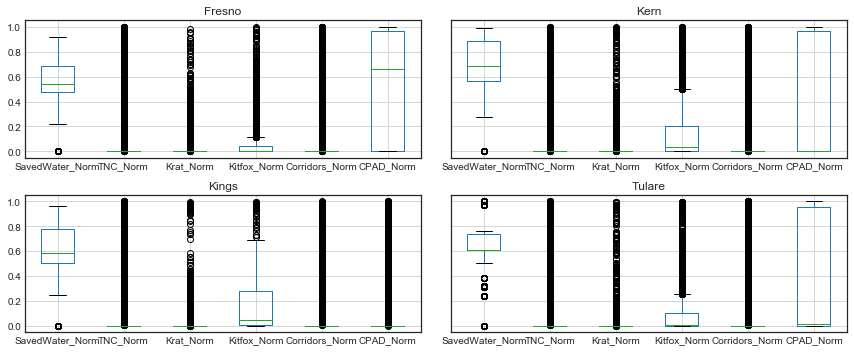

In [33]:
fields_valued[['County']+[f'{column}_Norm' for column in eco_service_cols]].groupby('County').boxplot()
plt.tight_layout()

In [34]:
area_normalized.describe()

count    91377.000000
mean         0.194063
std          0.374707
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.001261
dtype: float64

In [35]:
fields.loc[area_normalized[area_normalized>100].index, ['Crop2014', 'County', 'Acres', 'TNC', 'Krat', 'Kitfox', 'Corridors', 'CPAD']]

,Crop2014,County,Acres,TNC,Krat,Kitfox,Corridors,CPAD


In [36]:
fields[eco_service_cols].describe()

,SavedWater,TNC,Krat,Kitfox,Corridors,CPAD
count,91379.000000,91377.000000,91377.000000,91377.000000,91377.000000,91377.000000
mean,99.282175,1.472765,0.415672,2.273812,2.664543,7.834660
std,136.165391,12.366046,4.614042,9.750137,15.266066,27.620694
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,16.830000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,49.710000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,130.895000,0.000000,0.000000,0.247310,0.000000,0.000000
max,2110.030000,1600.868790,359.986097,428.806968,671.089096,1861.475338


#### Calculate area-weighted ecosystem service values

In [37]:
eco_service_cols

array(['SavedWater', 'TNC', 'Krat', 'Kitfox', 'Corridors', 'CPAD'],
      dtype=object)

In [38]:
norm_columns = [f'{eco_service}_Norm' for eco_service in eco_service_cols]
norm_columns

['SavedWater_Norm',
 'TNC_Norm',
 'Krat_Norm',
 'Kitfox_Norm',
 'Corridors_Norm',
 'CPAD_Norm']

In [39]:
for column, eco_service in list(zip(norm_columns, eco_service_cols)):
    new_col = f'{eco_service}_Total'
    fields[new_col] = fields[column] * fields['Acres']

In [54]:
fields[[f'{eco_service}_Norm' for eco_service in eco_service_cols]].isna().sum()

SavedWater_Norm    0
TNC_Norm           2
Krat_Norm          2
Kitfox_Norm        2
Corridors_Norm     2
CPAD_Norm          2
dtype: int64

In [41]:
fields.to_file(out_shp)

In [42]:
fields.columns

Index(['Crop2014', 'Acres', 'FID', 'geometry', 'County', 'PPIC_Regio',
       'Crop_PPIC', 'Price', 'Rotations', 'AdjustedPrice', 'FieldCropPrice',
       'WaterConsumption', 'SavedWater', 'TNC', 'Krat', 'Kitfox', 'Corridors',
       'CPAD', 'SavedWater_Norm', 'TNC_Norm', 'Krat_Norm', 'Kitfox_Norm',
       'Corridors_Norm', 'CPAD_Norm', 'SavedWater_Total', 'TNC_Total',
       'Krat_Total', 'Kitfox_Total', 'Corridors_Total', 'CPAD_Total'],
      dtype='object')

## Explore results 

#### Compare inputs to PPIC report
|Region|Land <br>(1,000s acres) <br>|Applied Water<br>(1,000s of acre-ft)<br>|Revenue <br>(2010 $, millions)<br>|
|:----:|:-------------:|:-----------------:|:----------------:|
|KR    |827           |2,958              |3,948|
|SE    |1,134         |3,662              |5,930|
|SW    |1,112         |3,177              |3,917|

In [43]:
total_revenue = fields['FieldCropPrice'].sum()
print (f'${total_revenue:,.2f} in annual revenue')

$22,310,336,871.18 in annual revenue


In [44]:
cropland = fields['Acres'].sum()
print(f'{cropland:,.0f} acres of cropland')

3,280,532 acres of cropland


In [45]:
applied_water = fields['SavedWater'].sum()
applied_water_s = (f'{applied_water:,.0f} acre-feet of applied water')

This example {{applied_water_s}} should work

In [46]:
pd.DataFrame({'Region': 'All', 'Land':[f'{cropland:,.0f}'], 'Water':[f'{applied_water:,.0f}'], 'Revenue':[f'${total_revenue:,.0f}']})

,Region,Land,Water,Revenue
0,All,"3,280,532","9,072,306","$22,310,336,871"


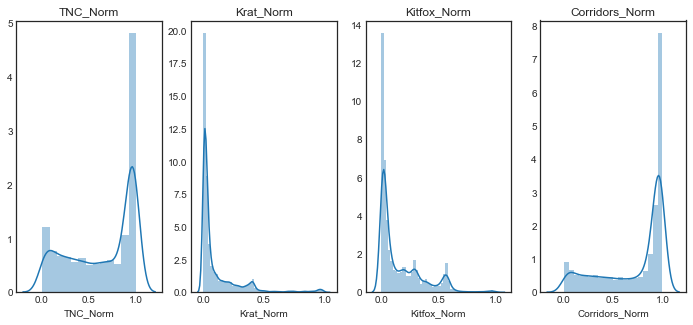

In [80]:
norm_cols = [f'{eco_service}_Norm' for eco_service in eco_service_cols]
fig, axes = plt.subplots (1,4)
for i in range(1,5):
    ax = axes[i-1]
    eco_service = norm_cols[i]
    sns.distplot(fields.loc[fields[eco_service] > 0, eco_service].dropna(), ax=ax)
    ax.set_title(eco_service)

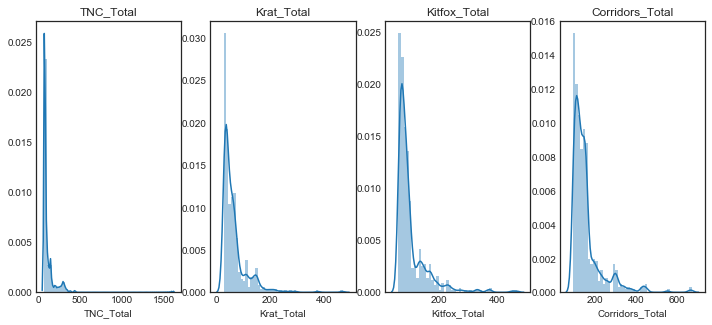

In [81]:
total_cols = [f'{eco_service}_Total' for eco_service in eco_service_cols]
fig, axes = plt.subplots (1,4)
for i in range(1,5):
    ax = axes[i-1]
    eco_service = total_cols[i]
    sns.distplot(fields.loc[fields[eco_service] > 0, eco_service].dropna().sort_values().tail(500), ax=ax)
    ax.set_title(eco_service)